In [1]:
import os
import cv2
import math
import random
import numpy as np
import pandas as pd
import itertools
from PIL import Image
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [2]:
def scale_ycrcb(img_ycrcb):
    """
    Retorna una imagen escalada en (-128,128)
    """
    tem = np.zeros(img_ycrcb.shape, dtype=int)
    tem[:,:,0] = img_ycrcb[:,:,0]
    tem[:,:,1] = img_ycrcb[:,:,1] + (-128)
    tem[:,:,2] = img_ycrcb[:,:,2] + (-128)
    return tem

In [3]:
def arrowsimg(array_dydx, defacing = 0):
    """
    image_dydx: dydx Channels of an image (2D)
    defacing: If the reference map is defacing with respect to the YCrCb map
    return: magnitudes and angles of the arrows
    """
    #___________________________________________________________________________
    assert(array_dydx.ndim == 3), "The array is not 3D array"
    assert(array_dydx.shape[2] == 2), "Dimension is not valid (Channels)"
    #___________________________________________________________________________
    array_dydx = np.array(array_dydx)
    magnitudes, angles = cv2.cartToPolar(array_dydx[:,:,1].astype(float),
                                         array_dydx[:,:,0].astype(float),
                                         angleInDegrees=True)
    if defacing != 0:
        for row in range(angles.shape[0]):
            for col in range(angles.shape[1]):
                angle = angles[row,col]
                if (0.0 <= angle < 90.0 ): # first quadrant
                    angles[row,col] = angle + (360 - defacing)
                elif (90.0 <= angle < 180.0 ): # second quadrant
                    if defacing == 90:
                        angles[row,col] = angle - defacing
                    else:
                        angles[row,col] = angle + (360 - defacing)
                elif (180.0 <= angle < 270.0 ): # third quadrant
                    if defacing == 270:
                        angles[row,col] = angle + (360 - defacing)
                    else:
                        angles[row,col] = angle - defacing
                elif (270.0 <= angle <= 360.0 ): # fourth quadrant
                    angles[row,col] = angle - defacing

    return magnitudes, angles

In [4]:
def tao_(mag, ang, tao):
    x_n = []
    y_n = []
    magnitud = []
    angulo = []
    for fil in range(mag.shape[0]):
        for col in range(mag.shape[1]):
            if(mag[fil][col] > tao):
                x_n.append(col)
                y_n.append(fil)
                magnitud.append(mag[fil][col])
                angulo.append(ang[fil][col])
    return x_n, y_n, magnitud, angulo

In [5]:
def painting(his_n, magnitud, c, angulo, x_n, y_n, i, a):
    #Flechas
    plt.figure(figsize=(20,20))
    #plt.subplot(221), 
    plt.imshow(a)
    dx_n, dy_n = cv2.polarToCart(np.array(magnitud), np.array(angulo), angleInDegrees=True)
    plt.quiver(x_n[::3], y_n[::3], dx_n[::3,::3], dy_n[::3,::3], 
                   color = 'white', alpha = .8,
                   scale_units = 'xy',
                   angles = 'xy')
    plt.axis("off")
    plt.savefig('/home/alejandra/HEART/Sunny_tesis/ARROWS/arrow'+ str(i) +'.png')
    
    """
    #Histogramas
    plt.figure(figsize=(15,4))
    plt.subplot(222), plt.bar(his_n[1][:-1],his_n[0], 40, align='center', color='purple', edgecolor='black')
    plt.subplot(223), plt.hist(magnitud, bins=100, width=0.4, color='purple')
    """

In [6]:
def desf_ang(angle):
    if (0.0 <= angle < 60.0):     # LCX 6
        angle = angle + 300.0
    elif (60.0 <= angle <= 120.0 ): # LAD 1
        angle = angle + 180.0
    elif (120.0 < angle <= 180.0): # LAD 2
        angle = angle + 60.0
    elif (-180.0<= angle < 0.0):
        angle = angle*(-1)
    return angle

## PARA UNA CARPETA DE IMAGENES

In [98]:
#Dirección del path para encontrar la carpeta TRAIN, se puede usar en el TEST también y en DESCRIPTOR
training = 'final_approach'

In [99]:
def hist_mag(folder, n, name):
    #___________
    ang_p = []
    ang_s = []
    ang_t = []
    ang_c = []
    ang_q = []
    ang_u = []
    mag_p = []
    mag_s = []
    mag_t = []
    mag_c = []
    mag_q = []
    mag_u = []
    c_conc =[]
    c_final = []
    #___________

    dir_ofI = "/home/alejandra/HEART/Sunny_tesis/HEART/OFLRV_PPM/"+folder+"/"+n+"I/"
    dir_ofD = "/home/alejandra/HEART/Sunny_tesis/HEART/OFLRV_PPM/"+folder+"/"+n+"D/"    
    
    descriptor = open("/home/alejandra/HEART/Sunny_tesis/"+training+"/TRAIN/"+name, "a")
    
    imageI = [dir_ofI+imagenI for imagenI in os.listdir(dir_ofI)]
    imageD = [dir_ofD+imagenD for imagenD in os.listdir(dir_ofD)]

    separaI = sorted(imageI,key = lambda x:int(x.split("/")[-1].split(".")[0]))
    separaD = sorted(imageD,key = lambda x:int(x.split("/")[-1].split(".")[0]))

    for i, imagen in enumerate(separaI):
        a = plt.imread(imagen)
        b = plt.imread(separaD[i])
        
        imgI = cv2.cvtColor(a, cv2.COLOR_BGR2YCrCb)
        imgD = cv2.cvtColor(b, cv2.COLOR_BGR2YCrCb)
        
        imgscI = scale_ycrcb(imgI)[:,:,1:]
        imgscD = scale_ycrcb(imgD)[:,:,1:]
        h, w, d = imgscD.shape 
        
        x = round(w/2) #row
        y = round(h/2) #column
        r = x if (x < y) else y

        magI, angI = arrowsimg(imgscI, 90)
        #_______________________________Partición modelo AHA_______________________________
        for col in range(imgscD.shape[0]):
            for row in range(imgscD.shape[1]):
                d_x = row-x
                d_y = col-y
                distance = np.sqrt((row-x)**2+(col-y)**2)
                magnitude = np.sqrt((d_x)**2+(d_y)**2) #igual que distance, corregir

                if(distance <= r):            
                    angle = math.atan2(d_y,d_x)*180/math.pi
                    angle = desf_ang(angle) 

                    if (0.0 <= angle < 60.0 ):     # LCX 6
                        ang_p.append(angle)
                        mag_p.append(magnitude)
                    elif (60.0 <= angle < 120.0 ): # LAD 1
                        ang_s.append(angle)
                        mag_s.append(magnitude)
                    elif (120.0 <= angle < 180.0 ): # LAD 2
                        ang_t.append(angle)
                        mag_t.append(magnitude)
                    elif (180.0 <= angle < 240.0 ): # RCA 3
                        ang_c.append(angle)
                        mag_c.append(magnitude)
                    elif (240.0 <= angle < 300.0 ): # RCA 4
                        ang_q.append(angle)
                        mag_q.append(magnitude)
                    elif (300.0 <= angle <= 360.0 ): # LCX 5
                        ang_u.append(angle)
                        mag_u.append(magnitude)
                        
        #___Histogramas___
        his_nI, binsI = np.histogram(angI, bins=12, range=[0,360], weights=magI) 
        his_p, bins_p = np.histogram(ang_p, bins=12, range=[0,360], weights=mag_p)
        his_s, bins_s = np.histogram(ang_s, bins=12, range=[0,360], weights=mag_s)
        his_t, bins_t = np.histogram(ang_t, bins=12, range=[0,360], weights=mag_t)
        his_c, bins_c = np.histogram(ang_c, bins=12, range=[0,360], weights=mag_c)
        his_q, bins_q = np.histogram(ang_q, bins=12, range=[0,360], weights=mag_q)
        his_u, bins_u = np.histogram(ang_u, bins=12, range=[0,360], weights=mag_u)
           
        c_conc = np.concatenate((c_conc, his_nI, his_p, his_s, his_t, his_c, his_q, his_u), axis =None) 
        #print("Total: ", len(c_conc), "\n")

    """
    NORMALIZACIÓN L1 - RAÍZ DE L1
    _____________________________
    """
    #c_conc = c_conc/np.sqrt(np.sum(c_conc))
    c_conc = preprocessing.normalize(c_conc.reshape(1, -1), norm='l1')
    c_conc = c_conc[0]
    
    print(c_conc.sum())
    c_final.append((c_conc))
    print(c_final)
    
    np.savetxt(descriptor, c_final)
    descriptor.close()

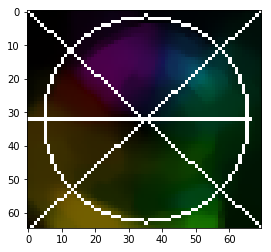

In [23]:
f = cv2.circle(imagen, (x, y), int(r-1), (255,255,255))
i = cv2.line(imagen, (0, 0), (round(w),round(h)), (255,255,255))
j = cv2.line(imagen, (0, y), (h, y), (255,255,255))
k = cv2.line(imagen, (0, h), (w, 0), (255,255,255))
plt.imshow(imagen)

## Descriptor global

#### Cambiar las direcciones

In [100]:
pri_pat = open("/home/alejandra/HEART/Sunny_tesis/DATASETS/an_pri_pat.txt", "r")
sec_pat = open("/home/alejandra/HEART/Sunny_tesis/DATASETS/n/n_sec_pat.txt", "r")
ter_pat = open("/home/alejandra/HEART/Sunny_tesis/DATASETS/n/n_ter_pat.txt", "r")
cua_pat = open("/home/alejandra/HEART/Sunny_tesis/DATASETS/n/n_cua_pat.txt", "r")


In [101]:
for i in pri_pat:
    print(i)
    hist_mag(i[:10], i[11], 'array_descriptor_final.txt')

for i in sec_pat:
    print(i)
    hist_mag(i[:11], i[12], 'array_descriptor_final.txt')

for i in ter_pat:
    print(i)
    hist_mag(i[:9], i[10], 'array_descriptor_final.txt')
    
for i in cua_pat:
    print(i)
    hist_mag(i[:7], i[8], 'array_descriptor_final.txt')

SC-HF-I-01 7

1.0
[array([3.97190225e-06, 2.65536489e-06, 5.42504191e-05, ...,
       0.00000000e+00, 8.15901167e-03, 7.86081459e-03])]
SC-HF-I-02 3

1.0
[array([1.89338070e-04, 1.44653754e-04, 5.89979138e-05, ...,
       0.00000000e+00, 8.13192267e-03, 7.94452591e-03])]
SC-HF-I-05 7

1.0
[array([0.00024184, 0.00016293, 0.00061719, ..., 0.        , 0.0080511 ,
       0.00776627])]
SC-HF-I-06 4

1.0000000000000002
[array([0.        , 0.        , 0.        , ..., 0.        , 0.00826133,
       0.0079594 ])]
SC-HF-I-07 4

1.0
[array([9.98649212e-04, 8.50568623e-05, 4.60432687e-06, ...,
       0.00000000e+00, 8.08911565e-03, 7.79347314e-03])]
SC-HF-I-08 3

1.0
[array([1.22879933e-05, 1.44836027e-04, 4.87748156e-05, ...,
       0.00000000e+00, 8.27561202e-03, 8.01704368e-03])]
SC-HF-I-09 9

1.0
[array([2.09058402e-05, 1.20940164e-05, 7.41241290e-05, ...,
       0.00000000e+00, 8.33674034e-03, 8.12467880e-03])]
SC-HF-I-10 9

1.0
[array([3.27202466e-04, 9.96978074e-05, 7.46015058e-05, ...,
  